## **Pacotes**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import os

## **Pré Processamento dos Dados**

In [168]:
# CARREGANDO OS DADOS
df = pd.read_csv(os.getcwd() + '\\data\\seoul_bike_data.csv', sep = ',', encoding = 'unicode_escape')

# TRADUZINDO O NOME DAS COLUNAS
df.columns = [
    'data',
    'qtde_bicicletas_alugadas',
    'hora',
    'temperatura',
    'umidade',
    'velocidade_do_vento',
    'visibilidade',
    'temperatura_ponto_de_orvalho',
    'radiacao_solar',
    'volume_de_chuva',
    'volume_de_neve',
    'estacao_do_ano',
    'feriado',
    'dia_util'
]

# TRANSFORMANDO OS DADOS DE DATA EM DATETIME
df['data'] = pd.to_datetime(df['data'], format = '%d/%m/%Y')

# CRIANDO UMA COLUNA SÓ COM O MÊS E O ANO
df['ano_e_mes'] = df['data'].apply(lambda data: datetime(year = data.year, month = data.month, day = 1))

# CRIANDO UMA COLUNA COM A DATA INCLUINDO A HORA
df['data_com_hora'] = np.nan
lista_data_com_hora = []
for i in df.index:
    ano = df.loc[i, 'data'].year
    mes = df.loc[i, 'data'].month
    dia = df.loc[i, 'data'].day
    hora = df.loc[i, 'hora']
    lista_data_com_hora.append(datetime(ano, mes, dia, hora))
df['data_com_hora'] = lista_data_com_hora

# CRIANDO UMA COLUNA COM O DIA DA SEMANA
df['dia_da_semana'] = df['data'].apply(lambda data: data.weekday())

# TRANSFORMANDO OS DIAS DA SEMANA DE NÚMERO PARA NOME
dicionario_dia_semana = {
    0: 'segunda',
    1: 'terça',
    2: 'quarta',
    3: 'quinta',
    4: 'sexta',
    5: 'sabado',
    6: 'domingo'
}
df['dia_da_semana'] = df['dia_da_semana'].map(dicionario_dia_semana)

# TRADUZINDO O NOME DAS ESTAÇÕES DO ANO PARA PORTUGUÊS
dicionario_estacao_do_ano = {
    'Summer': 'verao',
    'Spring': 'primavera',
    'Autumn': 'outono',
    'Winter': 'inverno'
}
df['estacao_do_ano'] = df['estacao_do_ano'].map(dicionario_estacao_do_ano)

# TRADUZINDO OS VALORES DA COLUNA FERIADO
df['feriado'] = df['feriado'].apply(lambda feriado: 'sim' if feriado == 'Holiday' else 'nao')

# TRADUZINDO OS VALORES DA COLUNA DIA UTIL
df['dia_util'] = df['dia_util'].apply(lambda dia_util: 'sim' if dia_util == 'Yes' else 'nao')

# CRIANDO UMA LISTA COM AS VARIÁVEIS NUMERICAS E REMOVENDO VARIÁVEIS QUE NÃO SÃO NECESSÁRIAS
variaveis_numericas = df.select_dtypes(include = ['int', 'float']).columns.to_list()
variaveis_numericas = [nome_coluna for nome_coluna in variaveis_numericas if nome_coluna not in ['qtde_bicicletas_alugadas']]

# CRIANDO UMA LISTA COM AS VARIÁVEIS CATEGÓRICAS
variaves_categoricas = df.select_dtypes(include = ['object']).columns.to_list()

## **Criando o Modelo**

In [191]:
class modelagem:

    def __init__(self, dataframe, nome_target, lista_modelos, lista_transformacoes, lista_variaveis):

        self.df = dataframe
        self.nome_target = nome_target
        self.lista_modelos = list(zip([str(nome).split('(')[0] for nome in lista_modelos], lista_modelos))
        self.lista_variaveis = lista_variaveis
        self.lista_transformacoes = list(zip([str(nome).split('(')[0] for nome in lista_transformacoes], lista_transformacoes, lista_variaveis))

    def treinar(self, estratificar = None, metodo_treino = 'holdout', percentual_teste = 0.3, kfolds = 5, pontuacao = 'r2'):

        X = self.df[list(set([variavel for lista in self.lista_variaveis for variavel in lista]))]
        y = self.df[self.nome_target]

        transformador = ColumnTransformer(transformers = self.lista_transformacoes, remainder = 'passthrough')

        if metodo_treino == 'holdout':

            X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = percentual_teste)

            for nome_modelo, modelo in self.lista_modelos:
                
                pipeline = Pipeline(
                    steps = [
                        ('pre_processamento', transformador),
                        ('modelo', modelo)
                    ])

                pipeline.fit(X_treino, y_treino)

                previsoes = pipeline.predict(X_teste)

                print(f'\nModelo: {nome_modelo}\nR2: {r2_score(y_teste, previsoes):.4f}\nMSE: {mean_squared_error(y_teste, previsoes):.2f}\nMAE: {mean_absolute_error(y_teste, previsoes):.2f}')

                df_previsao = pd.DataFrame({
                    'data_com_hora' : self.df.iloc[y_teste.index]['data_com_hora'],
                    'y_teste': y_teste,
                    'previsoes' : previsoes
                })
                
                df_previsao = df_previsao.sort_values('data_com_hora')

                # CRIANDO UM GRÁFICO PARA VISUALIZAR OS DADOS DE PREVISÃO E TESTE
                tamanho_serie = 60
                plt.figure(figsize = (12,4))
                plt.title(f'Previsões x Teste utilizando {nome_modelo}')
                plt.xlabel('Data e Hora')
                plt.ylabel('Quantidade de Bicicletas Alugadas')
                plt.plot(df_previsao['data_com_hora'][:tamanho_serie], df_previsao['y_teste'][:tamanho_serie], color = 'red', label = 'Teste')
                plt.plot(df_previsao['data_com_hora'][:tamanho_serie], df_previsao['previsoes'][:tamanho_serie], color = 'grey', label = 'Previsão')
                plt.legend()
                plt.show()

        elif metodo_treino == 'validacao_cruzada':

            for nome_modelo, modelo in self.lista_modelos:

                pipeline = Pipeline(
                    steps = [
                        ('pre_processamento', transformador),
                        ('modelo', modelo)
                    ])

                pontuacao_validacao_cruzada = cross_val_score(pipeline, X, y, cv = kfolds, scoring = pontuacao)

                print(f'\nModelo: {nome_modelo}\nMétrica: {pontuacao}\nKfolds: {kfolds}\nValores em cada Kfold: {[float(round(valor, 2)) for valor in pontuacao_validacao_cruzada]}\nValor: {pontuacao_validacao_cruzada.mean():.4f}')

        else:
            print("O método de treinamento não é valido. Não é 'validacao_cruzada' ou 'holdout'.")


Modelo: RandomForestRegressor
R2: 0.9122
MSE: 36750.02
MAE: 113.19


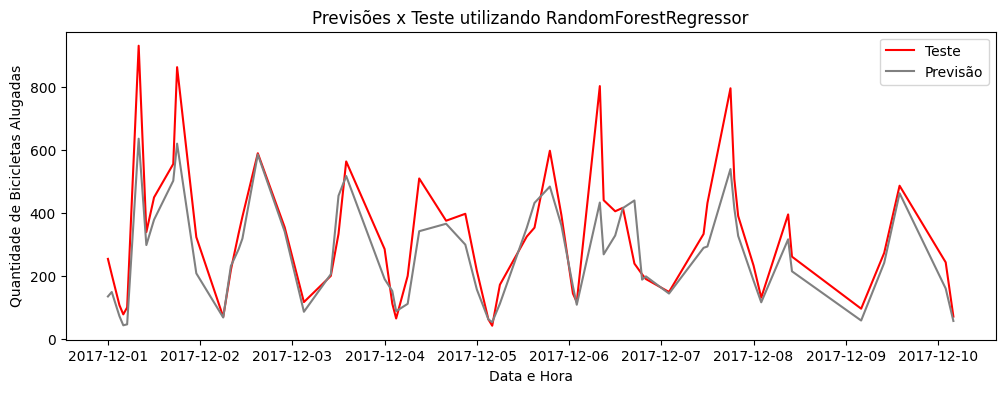


Modelo: LinearRegression
R2: 0.5432
MSE: 191141.41
MAE: 326.60


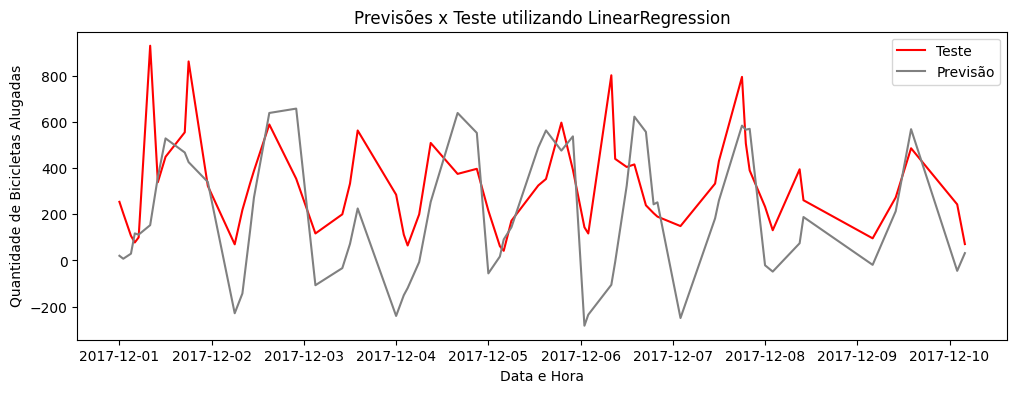

In [192]:
lista_modelos = [RandomForestRegressor(), LinearRegression()]
lista_variaveis = [variaveis_numericas, variaves_categoricas]
lista_transformacoes = [StandardScaler(), OneHotEncoder(sparse_output = False)]

modelagem_bicicletas = modelagem(dataframe = df,
                                 nome_target = 'qtde_bicicletas_alugadas',
                                 lista_modelos = lista_modelos,
                                 lista_transformacoes = lista_transformacoes,
                                 lista_variaveis = lista_variaveis)

modelagem_bicicletas.treinar(metodo_treino = 'holdout')